# Supervised Machine Learning Models

In [41]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_validate

import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer, LancasterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
# included so I can add latex code
from IPython.display import display, Math, Latex


Importing the IMDB review data

In [2]:
reviews = pd.read_csv("imdb_reviews.csv")



When we left last class, we were using a set of user reviews from IMDB to check the accuracy of the VADER sentiment analysis lexicon. We found that, overall, it did better than a random guess, but still had plenty of errors. But can we do better? 

Maybe! Instead of using a lexicon to determine if things are positive or negative, we can make a machine learning model that infers the terms that are associated with positive or negative documents automatically. In general, even fairly simple machine learning models can beat lexicon based methods. 

In **supervised machine learning**, we are focused on finding the relationship between a **label y** and **features x**.

$$ y = f(x) $$

"Learning" is finding a function f that minimizes future error in recovering y. 

For supervised learning, we must have a y variable that we know. That is, we need to have a the y variable in our dataset, so that we can build our model and use that model to predict y for future data.


<div class="alert alert-block alert-info">
<b>Note</b> in machine learning circles its common to use terms - like "learning", "training", "memorization" etc. - that can give the misleading impression that we're dealing with models that have some kind of human-like reasoning capcity. This is a useful metaphor because the idea of "learning" is a lot more intuitive than "minimizing a loss function", but what we're really doing here is fitting statistical models. Some of these models are very sophisticated, but none are conscious, they don't think, they don't have free will, and this is true even for the most cutting edge technologies. Just something to keep in mind. 
</div>


We're going to compare the predictions from the VADER sentiment lexicon to another widely used machine learning model called a Naive Bayes classifier. 


The Naive Bayes model is *old* and extremely simple by modern standards, but its performs surprisingly well for simple classification tasks and is often used as a sort of baseline model for assessing other machine classifiers. It works by using Baye's Theorem to calculate the probability of each class (C_k in the formula below) given the predictors (X). 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/52bd0ca5938da89d7f9bf388dc7edcbd546c118e)

It's considered "naive" because it assumes (incorrectly!) that each word is independent of all other words. This is another one of those clearly wrong assumptions that still works. 

# Pre-processing

Our goal here is to apply a mathematical model to text data, so a basic step is going to be converting words into some kind of a sensible numeric format.

In the last class, we used VADER, which does a lot of the "words-into-numbers" stuff for us. But for the current case we're going to need to do that process ourselves. As a starting point, we'll use what's commonly called a "bag-of-words" representation of our texts. A "bag-of-words" model simplifies texts by ignoring things like word-ordering, parts of speech, tone, context etc. and instead just focuses on "how many times a term occurs in a given document". To convert our reviews to a bag-of-words, we're going to do the following pre-processing steps:



1. **Tokenization** splits texts into smaller units. In the current case, this will be individual words without punctuation. But it could also be sentences, paragraphs or "n-gram" (groups of 1, 2, 3... words)
2. **Stopword Removal** removing common terms like "a", "and", "the" that are grammatically useful but uninformative for many text models
3. **Normalization** combining terms that are more-or-less equivalent by doing things like converting words to lower-case or removing word endings through stemming or lemmatization


(In some cases we may change the ordering of these steps, or we might do some cleaning and normalization and then decide, based on a closer look at our results, that we need to go back and do some additional cleaning. Our end goal, however, is generally to a representation of a text that is simple *enough* without sacrificing too much nuance or complexity.

Once we've made our bag-of-words, we'll use it to create what is called a "document-term-matrix" where each row represents a single document, each column represents a word that occurs anywhere in the entire collection of documents, and the cell values indicate a count of the number of times word `j` occurs in document `i`

For example, if I think about the sentences as a collection of three documents:

>    "See Spot Run. Spot runs fast. Run spot run!"


I would represent those documents as a document-term-matrix that looks like this:




<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">See</th>
    <th class="tg-0pky">Spot</th>
    <th class="tg-0pky">Run</th>
    <th class="tg-0pky">Fast</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-0pky">See Spot run.</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">0</td>
  </tr>
  <tr>
    <td class="tg-0pky">Spot runs fast</td>
    <td class="tg-0pky">0</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
  </tr>
  <tr>
    <td class="tg-0pky">Run Spot run.</td>
    <td class="tg-0pky">0</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">2</td>
    <td class="tg-0pky">0</td>
  </tr>
</tbody>
</table>

Note that, for real-world text analysis, the number of columns is going to grow exponentially as we include more documents, and most cells are just going to have values of `0`. This tendency to get very large "sparse" matrices is a recurring problem in text analysis and we'll have to make a lot of simplifications to keep things manageable. Many of the processing steps below are intended to allow us to combine or drop columns from our document term matrix. 


### Making the document-term-matrix

In [3]:
reviews.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


The `scikit-learn` package has a `CountVectorizer` function that will let us do all of the necessary processing in one step, but just to get a sense of what each component does, we'll try each part separately.

### 1. Tokenization

In the tokenization step, we'll split up documents into individual words. To do this, we'll use the `word_tokenize` function from the NLTK package.

In [4]:
text = 'See Spot run. Spot runs fast. Run Spot run!'

nltk.word_tokenize(text)

['See',
 'Spot',
 'run',
 '.',
 'Spot',
 'runs',
 'fast',
 '.',
 'Run',
 'Spot',
 'run',
 '!']

For the IMDB reviews, we're going to go a step further and lower case all of the texts. This will ensure that our document-term-matrix treats "This", "this", and "THIS" as a single word instead of creating separate columns for terms that mean the same thing, so our output will end up looking something like this:

In [5]:
# lower case and drop empty

nltk.word_tokenize(text.lower())

['see',
 'spot',
 'run',
 '.',
 'spot',
 'runs',
 'fast',
 '.',
 'run',
 'spot',
 'run',
 '!']

### 2. Stopword removal


Stopwords are words that are found commonly throughout a text and carry little semantic meaning. Examples of common stopwords are prepositions ("to", "on", "in"), articles ("the", "an", "a"), conjunctions ("and", "or", "but") and common nouns. For example, the words *the* and *of* are totally ubiquitous, so they won't serve as meaningful features, whether to distinguish documents from each other or to tell what a given document is about. You may also run into words that you want to remove based on where you obtained your corpus of text or what it's about. There are many lists of common stopwords available for you to use, both for general documents and for specific contexts, so you don't have to start from scratch.   

We can eliminate stopwords by checking all the words in our corpus against a list of commonly occuring stopwords that comes with the `nltk` package:

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neilb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop = stopwords.words('english')
stop[0:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

We'll convert this list of stopwords to a set (this will speed up some processing steps), and then we'll use it to filter the results from the tokenization step:

In [8]:
# tokenizing the stopword list and converting it to a list
eng_stopwords = set(stopwords.words('english'))

text = "This text contains a couple of stopwords."

tokens = nltk.word_tokenize(text.lower())
filtered_tokens = [w for w in tokens if w not in  eng_stopwords]

filtered_tokens

['text', 'contains', 'couple', 'stopwords', '.']

While we're filtering, we might also want to remove punctuation marks from the bag of words. So we'll use `.isalpha()` to remove anything that isn't an a letter:

In [9]:
filtered_tokens = [w for w in tokens if w not in  eng_stopwords and w.isalpha()]

filtered_tokens

['text', 'contains', 'couple', 'stopwords']

### 3. Stemming

Finally, we'll try to simplify our bag-of-words analysis by grouping together different inflections of the same terms. Word-endings that indicate things like pluralization and tense are useful in the context of human communication, but they're not informative when we're trying to do things like identify the topic or tone of a text.

There are two common approaches to this kind of normalization: 

- **Lemmatization** uses parts-of-speech and context clues to convert words to their basic dictionary form. 
- **Stemming** uses some simple hueristics to remove word inflections. 

Stemming is more error-prone than lemmatization, and sometimes results in words that you won't find in a dictionary, but it has the advantage of being much faster because it relies in simple rules whereas lemmatization considers word context and parts-of-speech. 

There are multiple stemming algorithms with different rule sets and differing strengths and weaknesses. In this notebook, we'll use the Snowball Stemmer. You'll notice this works pretty well for many words, but gives odd results for others:

In [10]:
# load the stemming algorthim
stemmer = SnowballStemmer("english")

In [11]:
# apply it to some terms
forms = ['lying', 'fisherman', 'change', 'systematic', 'stapled', 'catlike', 'argument', 'alphabetical']
print([stemmer.stem(i) for i in forms])


['lie', 'fisherman', 'chang', 'systemat', 'stapl', 'catlik', 'argument', 'alphabet']


You can contrast these results with the results from an alternate stemming algorithm, such as the LancasterStemmer

In [12]:
lancaster = LancasterStemmer()

In [13]:
forms = ['lying', 'fisherman', 'change', 'systematic', 'stapled', 'catlike', 'argument', 'alphabetical']
print([lancaster.stem(i) for i in forms])

['lying', 'fisherm', 'chang', 'system', 'stapl', 'catlik', 'argu', 'alphabet']


### Putting it all together

We'll wrap all three steps together in a single function that will take a document and return a processed bag of words. 






In [14]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return [stemmer.stem(token) for token in tokens if token not in eng_stopwords and token.isalpha()]

In [15]:
tokenize("This is a sentence that has been fully processed into a bag of words!! Isn't it great?")

['this', 'sentenc', 'fulli', 'process', 'bag', 'word', 'is', 'great']

## Using CountVectorizer

Now, we'll apply our tokenizer to the IMBD reviews and create the function that will output our term-document-matrix.

In addition to stemming and stopword removal, you might notice we also set values for `max_df` and `min_df`. `max_df=0.1` means that we remove all terms that occur in more than 10% of the documents. This can be a useful way to remove common terms that might not be captured by a standard stopword list, and it has the same basic motivation: we want to remove terms that are not really informative. Setting `min_df=.0025` has the effect of removing terms that occur in less than 0.25% of documents, so it gets rid of rare terms which - although they might be informative - don't show up in the corpus enough times for our topic model to really "learn" anything about them. Fiddling with both of these parameters may change your results for better or worse, so it may be worth experimenting with different values here if you're not satisfied with the results of your topic model

In [16]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return [stemmer.stem(token) for token in tokens if token not in eng_stopwords and token.isalpha()]


vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer = tokenize,
                             ngram_range=(0,1), # Tokens are individual words for now
                             strip_accents='unicode',
                             max_df = 0.1, # maximum number of documents in which word j occurs. 
                             min_df = .0025 # minimum number of documents in which word j occurs. 
                            )

Just to get a sense of how this looks, we'll apply it to the first 10 documents and then convert it back into a Pandas Dataframe. Note that you generally won't want/need to do this, its just a way to see what the function is doing:

In [17]:
dtm = vectorizer.fit_transform(reviews.text[:10])
pd.DataFrame.sparse.from_spmatrix(dtm).head()

C:\Users\neilb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,595,596,597,598,599,600,601,602,603,604
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
3,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,1,1,1,0,0
4,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


The columns here have numbers instead of names, but we can figure out which word is represented by each column by examining the `feature_names` from the vectorizer object:

In [18]:
vectorizer.get_feature_names_out()[:50]

array(['abrupt', 'access', 'accid', 'accord', 'acquaint', 'across',
       'action', 'actual', 'admir', 'adult', 'adventur', 'afteral', 'age',
       'agent', 'alic', 'along', 'alreadi', 'altern', 'alway', 'amaz',
       'america', 'american', 'andi', 'angl', 'anoth', 'anyon', 'anyth',
       'anywher', 'apart', 'appar', 'appeal', 'appear', 'around', 'arrog',
       'art', 'artist', 'ashley', 'asiat', 'asid', 'aspect', 'attend',
       'attract', 'audibl', 'audienc', 'audio', 'avoid', 'aw', 'awak',
       'away', 'backdrop'], dtype=object)

No we've got everything we need to process the data for text analysis.

# Training a model

One more caveat before we start: its extremely easy to make a model that "predict" data that's already part of the sample. A list of all U.S. presidential election winners in sequential order is a perfect predictor of all past elections, but its a terrible model for predicting the next one. Creating a model that predicts well inside a sample but poorly outside the sample is called "overfitting", and its a recurring problem for this kind of machine learning. In order to avoid that problem, we're going to randomly split our data into a training set that we'll feed to the model, and a validation (or training) set, that we'll use to assess our accuracy. 

The `train_test_split` function will do this for us. We'll use 80% of our data for training and the remaining 20% for validation: 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(reviews.text, reviews.label,
                                     test_size=0.20, # 20% of observations for validation
                                     random_state = 999) # this is a random process, so you want to set a random seed! 


In [20]:
# now we have a training set and testing set:


Now we can apply the the vectorization function to make our bag of words:

In [21]:
train_dtm = vectorizer.fit_transform(X_train)

# get the names of the features for future use
features = vectorizer.get_feature_names_out()

# Note! We use transform instead of fit_transform to ensure that the vectorization function
# doesn't update anyhing based on the testing data
test_dtm = vectorizer.transform(X_test) 



C:\Users\neilb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Now we'll fit our Naive Bayes model:

In [22]:
nb = MultinomialNB()
nb.fit(train_dtm, y_train)



MultinomialNB()

Now we can use the trained model to predict data in the testing set, and compare the results in a confusion matrix:

In [23]:
preds = nb.predict(test_dtm)

pd.crosstab(y_test, preds,  margins=True).rename_axis(index = 'Truth', columns='Predictions')


Predictions,0,1,All
Truth,,,
0,418,81,499
1,94,407,501
All,512,488,1000


`scikit-learn` has a built in function that will allow us to get some additional information about our model performance. 



In [24]:
print(classification_report(y_test, preds, 
                            # add target_names to show labels in the report:
                            target_names=['negative', 'positive']))

# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test, preds))
print("balanced accuracy: ", balanced_accuracy_score(y_test, preds))

              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       499
    positive       0.83      0.81      0.82       501

    accuracy                           0.82      1000
   macro avg       0.83      0.83      0.82      1000
weighted avg       0.83      0.82      0.82      1000

cohens kappa:  0.6500167991936388
balanced accuracy:  0.8250253001012005


Here's how we can intepret these metrics:

| **metric**                  | Description                                                                                                                               |
|-----------------------------|-------------------------------------------------------------------------------------------------------------------------------------------|
| **accuracy** | % of predictions that are accurate                                                                                                        |
| **recall**                  | % of actually positive reviews that were correctly classified as positive                                                                 |
| **precision**               | % of predicted positive reviews that were actually positive                                                                               |
| **f-1**                     | Harmonic mean of precision and recall. Used as an overall measure of model performance. The maximum score is 1. Scores above .5 are poor. |
| **Cohen's Kappa**           | Measures how well the model performs relative to a model based on the marginal probabilities of each class. Higher is better.             |
| **Balanced Accuracy**       | Accuracy score after accounting for imbalance between each class                                                                          |

<h4 style="color:red;font-weight: bold;">Question 1: Run the code below to get predictions from the VADER sentiment analysis tool. Then create a classification report that compares the results from VADER to the actual values of y_test</h4>

In [27]:
sia = SentimentIntensityAnalyzer()
vader_scores = [sia.polarity_scores(i)['compound'] for i in X_test]
vader_preds = [i>=.05 for i in vader_scores]

# now compare vader_preds to y_test



So how does the naive bayes model perform relative to VADER? More importantly why is there a difference? Primarily, this probably comes down to the differences in context: there are a lot of terms that indicate negative views in the IMDB corpus that probably wouldn't indicate negative views in other contexts. We can get a sense of this by extracting some of the most important features from the model.



In [28]:
# get the probability of positive and negative classes
prob_neg = y_train.value_counts(normalize=True)[0]
prob_pos = y_train.value_counts(normalize=True)[1]
# making a data frame with the results
df_nbf = pd.DataFrame()
df_nbf.index = features
vals= np.e**(nb.feature_log_prob_[0, :])
# np.e exponentiates the logged odds, so this turns them back into probabilities 
df_nbf['pos'] = np.e**(nb.feature_log_prob_[1, :]) # log probability for negative class
df_nbf['neg'] = np.e**(nb.feature_log_prob_[0, :]) # log probability for positive class
# terms with the highest ratio of association with predicting one class
# p(positive|word)/p(negative|word) * (p(positive)/p(negative))
df_nbf['odds_positive'] = (df_nbf['pos']/df_nbf['neg'])*(prob_pos /prob_neg)


Now we can look at some features associated with positive or negative reviews

In [29]:
df_nbf.sort_values('odds_positive',ascending=False)['odds_positive']


matthau      19.167173
nyc          16.140777
depardieu    15.131978
immers       11.096784
von          10.760518
               ...    
pointless     0.054530
seagal        0.051733
downhil       0.045854
uwe           0.042033
boll          0.030570
Name: odds_positive, Length: 4139, dtype: float64

And with a little reshaping, we can plot them

[Text(0.5, 0, 'Strength of association with positive\n vs. negative reviews'),
 Text(0, 0.5, 'term')]

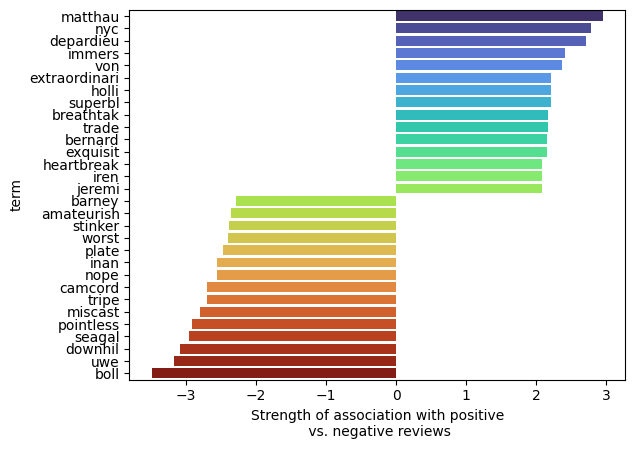

In [30]:
top = df_nbf.sort_values('odds_positive',ascending=False).reset_index()
top_bottom = pd.concat([top.iloc[:15], top.iloc[-15:]])
ax = sns.barplot(data=top_bottom,
                 y= 'index',    
                 hue='index',
                x=np.log(top_bottom['odds_positive']),dodge=False, palette='turbo')
ax.set(xlabel='Strength of association with positive\n vs. negative reviews', ylabel='term')


The results here should give you a rough idea of how and why the Naive Bayes model is able to outperform VADER: there are a number of terms - particularly the names of actors and directors - that are strongly associated with negative or positive reviews in this corpus that wouldn't really be seen as indicating negativity elsewhere. It might also give you a sense of one of the key risks of using machine learning approaches: its easy to unintentionally fit models that make inferences that might reflect biases - including cultural, racial, or gender biases - that we don't want to perpetuate. 

# Improving the processing

Naive Bayes is generally considered a baseline model for classification, but sometimes we can improve our results with some additional pre-processing.

I'll try a new processing step that includes "N-grams" and that reweights the data so that certain terms count for more using the TF-IDF scheme.

`N-grams` are essentially sequences of words. If I take a sentence like "See Spot run", the UNI-grams are just: "See", "Spot", and "run". However, I could also include "Bi-grams" or "Tri-grams" in my bag of words. The list of bigrams would be: "See_Spot" and "Spot_run". Adjusting the `ngram_range` from `(0,1)` to `(0,2)` argument would create a document-term-matrix that included all single words and also all bi-grams in the collection of texts. This can improve the performance of our classifier, because it allows us to include a bit more context about each word. 

TF-IDF (Term Frequency - Inverse Document Frequency) is a common weighting scheme for texts that causes rare words to recieve a bigger weight in the term-document matrix. Essentially, if a term only occurs in 10% of documents, I'll re-weight each occurence so that they count 10x as much. The effect will be that rare words are treated as more important in our model, while common words are treated as less important. 

Here's our new text pre-processor.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [42]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return [stemmer.stem(token) for token in tokens if token not in eng_stopwords and token.isalpha()]


tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                             tokenizer = tokenize,
                             ngram_range=(0,2), # groups of multiple words
                             strip_accents='unicode',
                             max_df = 0.1, # maximum number of documents in which word j occurs. 
                             min_df = .0025 # minimum number of documents in which word j occurs. 
                            )



Now we can apply it to the data and fit a new model to check our results:

In [43]:
train_dtm = tfidf_vectorizer.fit_transform(X_train)
features = tfidf_vectorizer.get_feature_names_out()
test_dtm = tfidf_vectorizer.transform(X_test) 

# fit the model
tfidf_nb = MultinomialNB()
tfidf_nb.fit(train_dtm, y_train)


C:\Users\neilb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MultinomialNB()

In [44]:
preds = tfidf_nb.predict(test_dtm)
print(classification_report(y_test, preds, 
                            # add target_names to show labels in the report:
                           target_names=['negative', 'positive']))

# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test, preds))
print("balanced accuracy: ", balanced_accuracy_score(y_test, preds))

              precision    recall  f1-score   support

    negative       0.87      0.82      0.84       499
    positive       0.83      0.87      0.85       501

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

cohens kappa:  0.6979685887332283
balanced accuracy:  0.8489493957975832


In [45]:
def nbPredictorPlot(model, labels, features):
    # get the probability of positive and negative classes
    prob_neg = y_train.value_counts(normalize=True)[0]
    prob_pos = y_train.value_counts(normalize=True)[1]
    # making a data frame with the results
    df_nbf = pd.DataFrame()
    df_nbf.index = features
    vals= np.e**(tfidf_nb.feature_log_prob_[0, :])
    # np.e exponentiates the logged odds, so this turns them back into probabilities 
    df_nbf['pos'] = np.e**(tfidf_nb.feature_log_prob_[1, :]) # log probability for negative class
    df_nbf['neg'] = np.e**(tfidf_nb.feature_log_prob_[0, :]) # log probability for positive class
    # terms with the highest ratio of association with predicting one class
    # p(positive|word)/p(negative|word) * (p(positive)/p(negative))
    df_nbf['odds_positive'] = (df_nbf['pos']/df_nbf['neg'])*(prob_pos /prob_neg)
    top = df_nbf.sort_values('odds_positive',ascending=False).reset_index()
    top_bottom = pd.concat([top.iloc[:15], top.iloc[-15:]])


[Text(0.5, 0, 'Strength of association with positive\n vs. negative reviews'),
 Text(0, 0.5, 'term')]

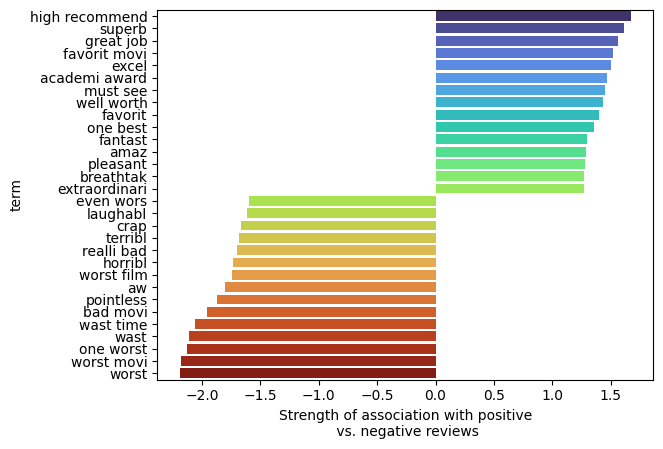

In [46]:
# get the probability of positive and negative classes
prob_neg = y_train.value_counts(normalize=True)[0]
prob_pos = y_train.value_counts(normalize=True)[1]
# making a data frame with the results
df_nbf = pd.DataFrame()
df_nbf.index = features
vals= np.e**(tfidf_nb.feature_log_prob_[0, :])
# np.e exponentiates the logged odds, so this turns them back into probabilities 
df_nbf['pos'] = np.e**(tfidf_nb.feature_log_prob_[1, :]) # log probability for negative class
df_nbf['neg'] = np.e**(tfidf_nb.feature_log_prob_[0, :]) # log probability for positive class
# terms with the highest ratio of association with predicting one class
# p(positive|word)/p(negative|word) * (p(positive)/p(negative))
df_nbf['odds_positive'] = (df_nbf['pos']/df_nbf['neg'])*(prob_pos /prob_neg)
top = df_nbf.sort_values('odds_positive',ascending=False).reset_index()
top_bottom = pd.concat([top.iloc[:15], top.iloc[-15:]])
ax = sns.barplot(data=top_bottom,
                 y= 'index',    
                 hue='index',
                x=np.log(top_bottom['odds_positive']),dodge=False, palette='turbo')
ax.set(xlabel='Strength of association with positive\n vs. negative reviews', ylabel='term')



<h4 style="color:red;font-weight: bold;">Question 2: Try changing the pre-processing steps for the reviews data. Consider making changes to `max_df` or `min_df`, or use a different stemming algorithm.  What steps you choose here is up to you. Fit a new naive bayes model and compare your results.</h4>

## Fitting a different model

Can we do better with a better model? The Naive Bayes classifier, after all, fails to account for correlations between predictors and can't really handle interactive relationships. Support Vector Machines are an alternative machine learning algorithm that can account for these kinds of differences. So does it produce a better predictor?




In [47]:
 
from sklearn.svm import SVC
#from sklearn.naive_bayes import BernoulliNB
model = SVC()
#model = BernoulliNB(binarize= 1)
model.fit(train_dtm,y_train)



SVC()

In [48]:
preds = model.predict(test_dtm)
print(classification_report(y_test, preds, 
                            # add target_names to show labels in the report:
                            target_names=['negative', 'positive']))

# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test, preds))
print("balanced accuracy: ", balanced_accuracy_score(y_test, preds))

              precision    recall  f1-score   support

    negative       0.88      0.83      0.85       499
    positive       0.84      0.89      0.86       501

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

cohens kappa:  0.7179638993791205
balanced accuracy:  0.858937435749743


# Extra stuff (if we get to it)

## Making a pipeline

I've got a lot of steps here that I need to apply repeatedly to the data. `scikitlearn` provides a `Pipeline` class that will allow us to combine several processing and prediction steps into a single function so that we can concisely apply a model in a bunch of different contexts. I'll create a pipeline that performs the text processing and applying a Naive Bayes model in one step:

In [49]:
# Create a pipeline
pipeline = Pipeline([
    ('tfidf',TfidfVectorizer(analyzer = 'word',
                            # tokenizer = tokenize,
                             ngram_range=(0,1), # groups of multiple words
                             strip_accents='unicode',
                             max_df = 0.1, # maximum number of documents in which word j occurs. 
                             min_df = .0025 # minimum number of documents in which word j occurs. 
                            )),
    ('naivebayes',MultinomialNB())
])





Calling the pipeline will give me a summary of the steps involved in using it:

In [50]:
pipeline

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.1, min_df=0.0025, ngram_range=(0, 1),
                                 strip_accents='unicode')),
                ('naivebayes', MultinomialNB())])

Now, I can apply it to some training data to create a trained model:

In [51]:

pipeline.fit(reviews.text, reviews.label)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.1, min_df=0.0025, ngram_range=(0, 1),
                                 strip_accents='unicode')),
                ('naivebayes', MultinomialNB())])

And now I have a trained model that can take a list of entirely new texts and classify them as either positive (1) or negative (0)

In [52]:
new_reviews = ["This movie was great", 
               "This is my favorite movie", 
               "I hated this movie!", 
               "Worst movie ever"]

print(pipeline.predict(new_reviews))


[1 1 0 0]


## K-fold cross validation

Although its unlikely, given how many test examples we have, we might want to make sure that our performance with this model isn't just a function of random chance, and we also want to avoid over-fitting to a single test data set. To avoid this problem, we'll often use k-fold cross validation. In K-fold cross validation, we separate the data into "K" equally sized groups, and then loop through the folds using each one as the validation data and all of the remaining observations as training data. Scikit-learn has an easy method for running k-fold cross validation and getting some overall metrics. I'll create a new pipeline for this, but this is just to make sure I get a model that hasn't "seen" any of the reviews data before 

In [53]:
cross_validation_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer(analyzer = 'word',
                            # tokenizer = tokenize,
                             ngram_range=(0,1), # groups of multiple words
                             strip_accents='unicode',
                             max_df = 0.1, # maximum number of documents in which word j occurs. 
                             min_df = .0025 # minimum number of documents in which word j occurs. 
                            )),
    ('naivebayes',MultinomialNB())
])


cross_val = cross_validate(cross_validation_pipeline, 
               reviews.text, 
               reviews.label, 
               cv=40,
               scoring =['f1', 'balanced_accuracy']
              
              )


In [54]:
pd.DataFrame(cross_val).describe()

,fit_time,score_time,test_f1,test_balanced_accuracy
count,40.000000,40.000000,40.000000,40.000000
mean,0.564000,0.015746,0.846313,0.846393
std,0.083156,0.002939,0.032429,0.031659
min,0.524265,0.012526,0.784000,0.784050
25%,0.530421,0.014003,0.823292,0.824405
50%,0.534948,0.015008,0.847961,0.847798
75%,0.555049,0.016131,0.873016,0.872024
max,0.889608,0.028000,0.909091,0.911802
